In [3]:
import os
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_curve, auc, roc_curve

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,6)
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  # Ajusta según tus cores lógicos

In [4]:
# ============================
# 0) Cargar modelos y preprocesadores
# ============================
models_path = r"C:/PROY_FINAL_ML/models/"
best_ridge = joblib.load(os.path.join(models_path, "best_ridge.pkl"))
best_hgb   = joblib.load(os.path.join(models_path, "best_hgb.pkl"))
best_hgb_clf = joblib.load(os.path.join(models_path, "best_hgb_clf.pkl"))
preproc_reg = joblib.load(os.path.join(models_path, "preproc_reg.pkl"))
preproc_clf = joblib.load(os.path.join(models_path, "preproc_clf.pkl"))

# ============================
# 1) Cargar datasets y features
# ============================
df = pd.read_parquet("C:/PROY_FINAL_ML/data/processed/cba_clean.parquet")

X_train = joblib.load("C:/PROY_FINAL_ML/data/processed/X_train.pkl")
X_valid = joblib.load("C:/PROY_FINAL_ML/data/processed/X_valid.pkl")
X_test  = joblib.load("C:/PROY_FINAL_ML/data/processed/X_test.pkl")

y_train = joblib.load("C:/PROY_FINAL_ML/data/processed/y_train.pkl")
y_valid = joblib.load("C:/PROY_FINAL_ML/data/processed/y_valid.pkl")
y_test  = joblib.load("C:/PROY_FINAL_ML/data/processed/y_test.pkl")

y_train_cls = joblib.load("C:/PROY_FINAL_ML/data/processed/y_train_cls.pkl")
y_valid_cls = joblib.load("C:/PROY_FINAL_ML/data/processed/y_valid_cls.pkl")
y_test_cls  = joblib.load("C:/PROY_FINAL_ML/data/processed/y_test_cls.pkl")

num_feats = joblib.load("C:/PROY_FINAL_ML/data/processed/num_feats.pkl")
cat_feats = joblib.load("C:/PROY_FINAL_ML/data/processed/cat_feats.pkl")

print("✅ Datasets y listas de features cargados correctamente.")

✅ Datasets y listas de features cargados correctamente.


In [5]:
# ============================
# 2) Funciones métricas
# ============================
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

In [6]:
# ============================
# 3) Predicciones
# ============================
# Regresión
y_pred_ridge = best_ridge.predict(X_test)
y_pred_hgb   = best_hgb.predict(X_test)

# Clasificación
y_pred_clf   = best_hgb_clf.predict(X_test)
y_proba_clf  = best_hgb_clf.predict_proba(X_test)[:,1]

In [7]:
# ============================
# 4) Métricas
# ============================
metrics_reg = pd.DataFrame({
    "Model": ["Ridge", "HGBReg"],
    "RMSE": [rmse(y_test, y_pred_ridge), rmse(y_test, y_pred_hgb)],
    "MAE":  [mae(y_test, y_pred_ridge), mae(y_test, y_pred_hgb)],
    "R2":   [r2_score(y_test, y_pred_ridge), r2_score(y_test, y_pred_hgb)]
})

metrics_clf = pd.DataFrame({
    "Model": ["HGBCls"],
    "Accuracy": [accuracy_score(y_test_cls, y_pred_clf)],
    "F1-macro": [f1_score(y_test_cls, y_pred_clf, average="macro")],
    "ROC-AUC": [roc_auc_score(y_test_cls, y_proba_clf)]
})

print("=== Métricas Regresión ===")
print(metrics_reg)
print("\n=== Métricas Clasificación ===")
print(metrics_clf)

# Crear carpeta para resultados si no existe
results_dir = r"C:/PROY_FINAL_ML/results"
os.makedirs(results_dir, exist_ok=True)

# Guardar resultados en CSV
metrics_reg.to_csv(os.path.join(results_dir, "metrics_reg.csv"), index=False)
metrics_clf.to_csv(os.path.join(results_dir, "metrics_clf.csv"), index=False)

=== Métricas Regresión ===
    Model      RMSE       MAE        R2
0   Ridge  0.802967  0.334759  0.875169
1  HGBReg  0.737413  0.237161  0.894719

=== Métricas Clasificación ===
    Model  Accuracy  F1-macro   ROC-AUC
0  HGBCls  0.927846  0.670325  0.896816


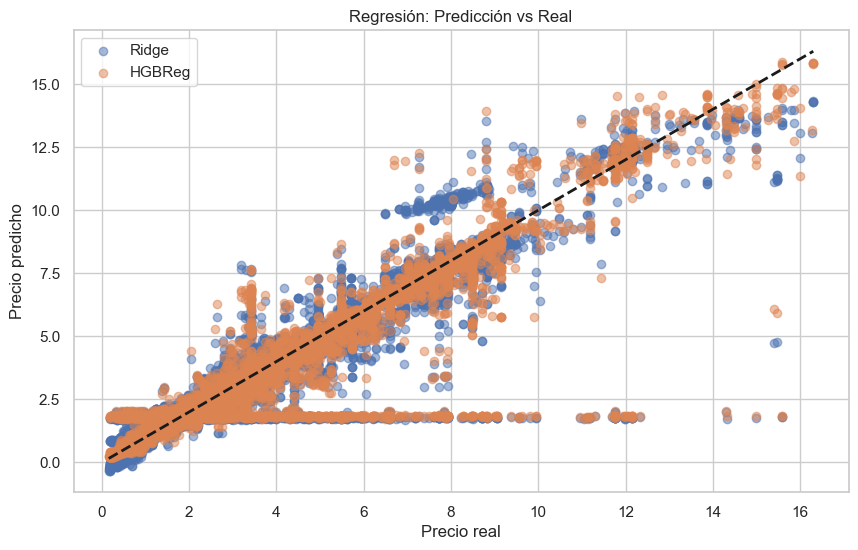

In [8]:
# ============================
# 5) Gráficas – Regresión
# ============================
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_ridge, alpha=0.5, label="Ridge")
plt.scatter(y_test, y_pred_hgb, alpha=0.5, label="HGBReg")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Precio real")
plt.ylabel("Precio predicho")
plt.title("Regresión: Predicción vs Real")
plt.legend()
plt.show()

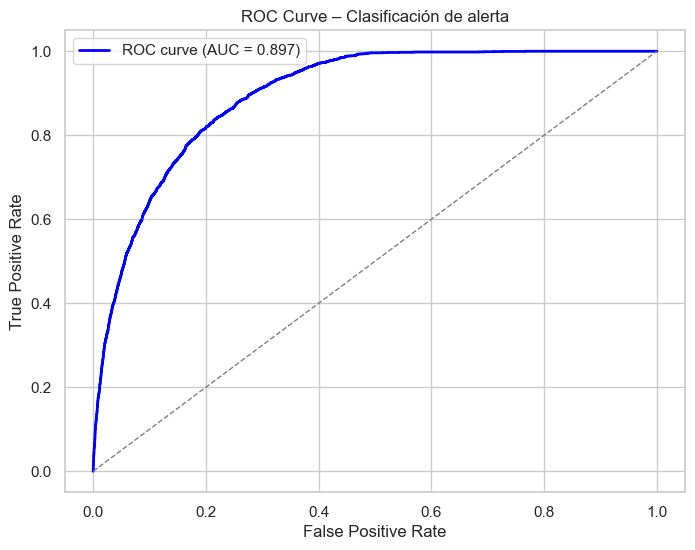

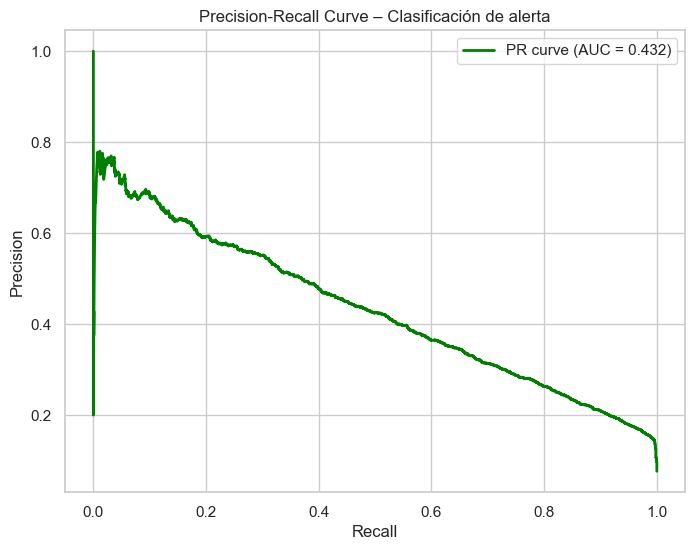

In [9]:
# ============================
# 6) Gráficas – Clasificación ROC y PR
# ============================
fpr, tpr, _ = roc_curve(y_test_cls, y_proba_clf)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Clasificación de alerta')
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(y_test_cls, y_proba_clf)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve – Clasificación de alerta')
plt.legend()
plt.show()

100%|===================| 35645/35660 [01:56<00:00]        

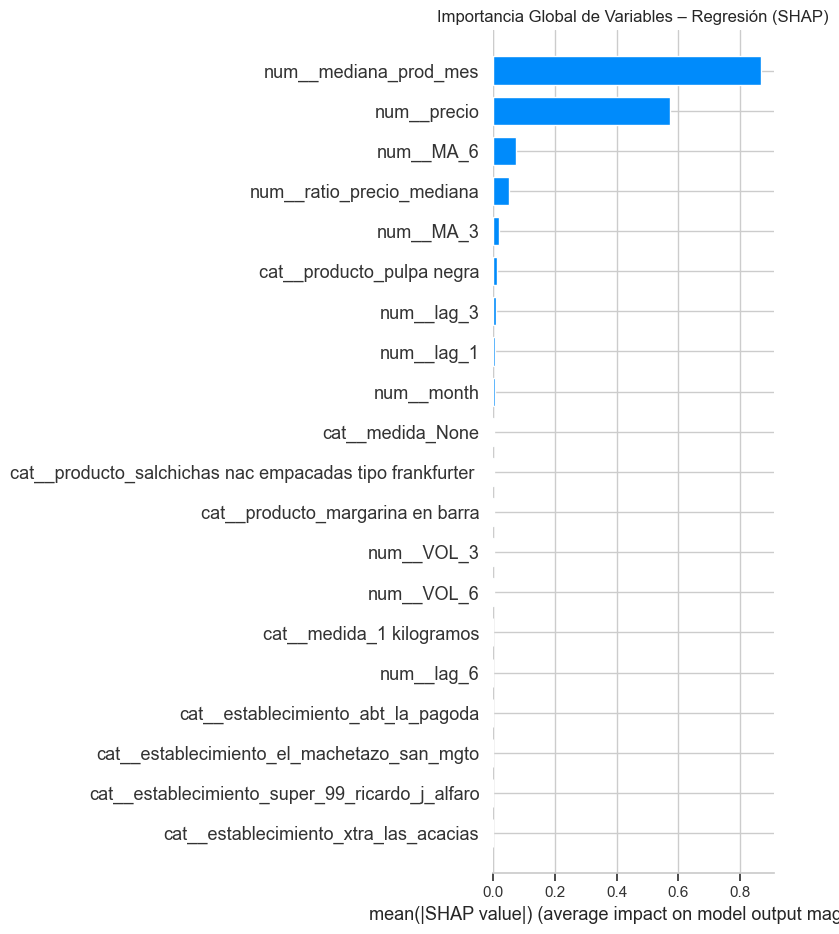

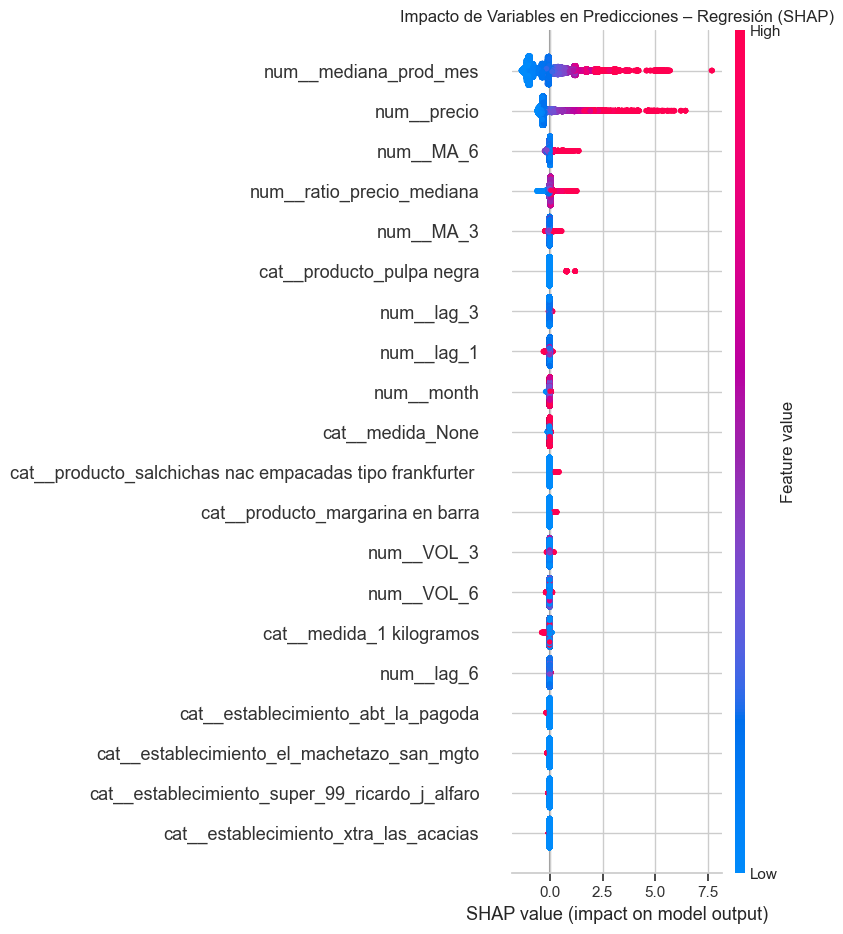

100%|===================| 35547/35660 [03:29<00:00]        

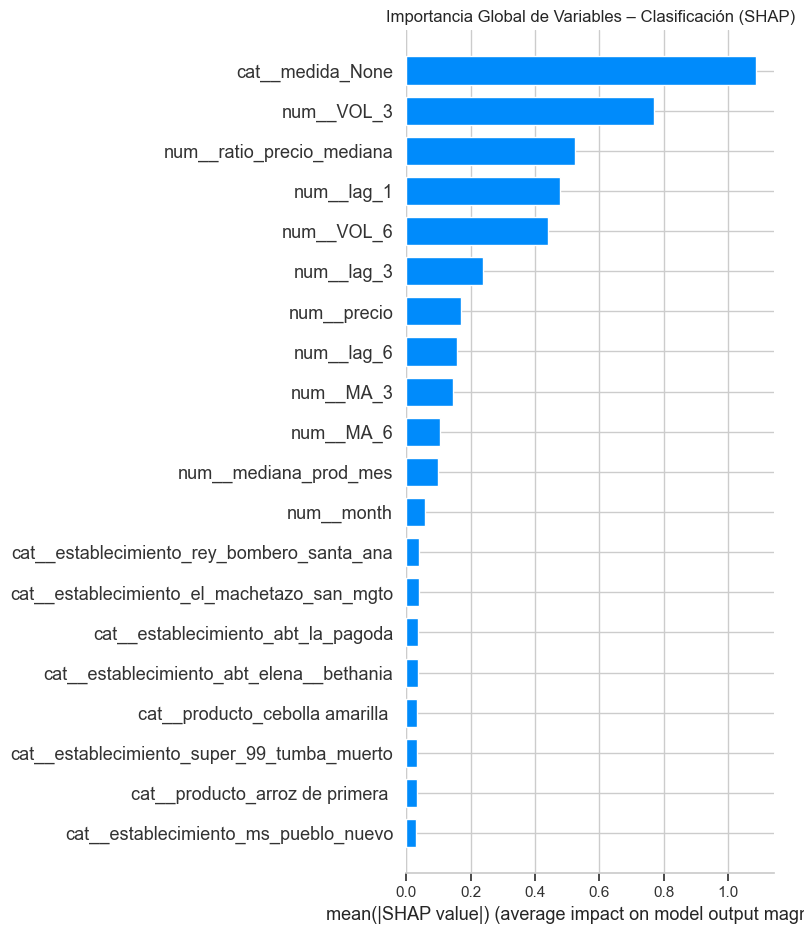

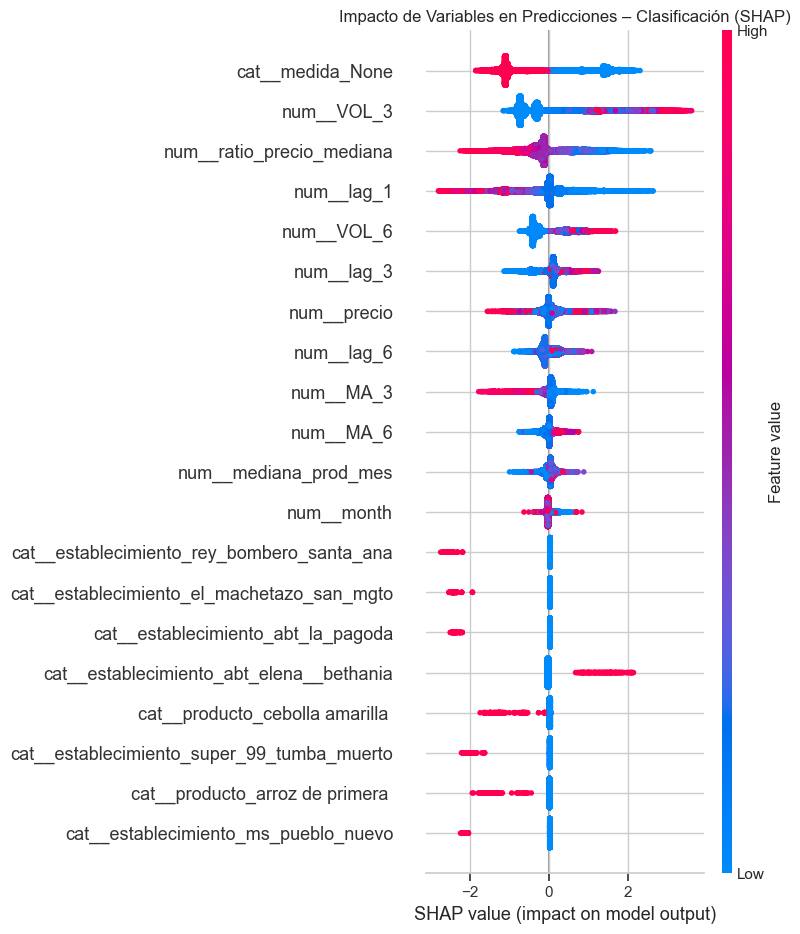

In [11]:
# ============================
# 7) SHAP – Explicabilidad
# ============================
# Para Regresión (best_hgb)
X_test_trans = preproc_reg.transform(X_test)
explainer_hgb = shap.Explainer(best_hgb["model"], X_test_trans)
shap_values_hgb = explainer_hgb(X_test_trans, check_additivity=False)#

plt.title("Importancia Global de Variables – Regresión (SHAP)")
shap.summary_plot(
    shap_values_hgb,
    X_test_trans,
    feature_names=preproc_reg.get_feature_names_out(),
    plot_type="bar",
    show=True
)

plt.title("Impacto de Variables en Predicciones – Regresión (SHAP)")
shap.summary_plot(
    shap_values_hgb,
    X_test_trans,
    feature_names=preproc_reg.get_feature_names_out(),
    show=True
)

# Para Clasificación (best_hgb_clf)
X_test_trans_cls = preproc_clf.transform(X_test)
explainer_hgb_cls = shap.Explainer(best_hgb_clf["model"], X_test_trans_cls)
shap_values_hgb_cls = explainer_hgb_cls(X_test_trans_cls, check_additivity=False)

plt.title("Importancia Global de Variables – Clasificación (SHAP)")
shap.summary_plot(
    shap_values_hgb_cls,
    X_test_trans_cls,
    feature_names=preproc_clf.get_feature_names_out(),
    plot_type="bar",
    show=True
)

plt.title("Impacto de Variables en Predicciones – Clasificación (SHAP)")
shap.summary_plot(
    shap_values_hgb_cls,
    X_test_trans_cls,
    feature_names=preproc_clf.get_feature_names_out(),
    show=True
)


📊 Análisis de error por: producto
                                   n_obs      RMSE       MAE        R2  \
producto                                                                 
huevos medianos de gallina          1244  2.450610  1.016106  0.387914   
leche en polvo entera instant nea   1402  1.414299  0.721648  0.456761   
leche fresca y pasteurizada         1659  1.191120  0.554204  0.593445   
queso amarillo                      1231  1.066723  0.540275  0.647275   
azcar morena                        1740  0.963242  0.516033  0.850397   
guineos                              990  0.786986  0.314745  0.949836   
leche evaporada                     1405  0.725769  0.373814  0.695744   
soda en envase pl stico             1622  0.610379  0.207459  0.968895   
pasta de tomate                     1506  0.397517  0.162442  0.949310   
queso blanco prensado bajo en sal   1862  0.379206  0.115565  0.976712   

                                   y_real_avg  y_pred_avg  RMSE_normalized  

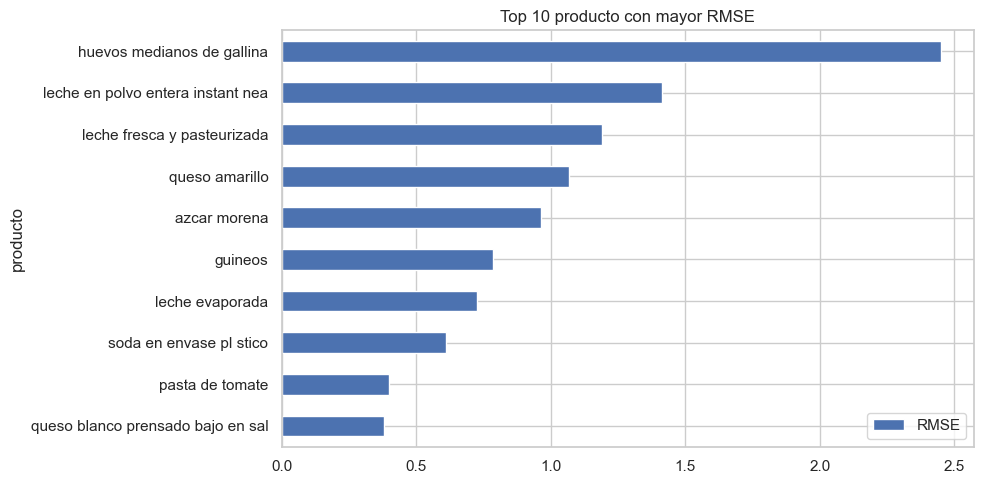


📊 Análisis de error por: establecimiento
                           n_obs      RMSE       MAE        R2  y_real_avg  \
establecimiento                                                              
minisuper_chonsito           358  2.132859  0.566203  0.506174    2.843473   
miinimarket_vicky            354  1.877260  0.493315  0.519875    2.581731   
ms_ricky_liu                 305  1.752608  0.469395  0.566522    2.592962   
abt_panam_viejo              245  1.685583  0.412877  0.564577    2.580558   
rey_de_via_espaa             300  1.433898  0.540418  0.822076    3.690906   
super_99_tumba_muerto        374  1.358221  0.524501  0.833760    3.662995   
super_99_el_dorado           375  1.302354  0.540592  0.859320    3.804862   
ms_fuente_de_oro__san_fco    376  1.138335  0.455073  0.774990    2.602114   
super_99_camino_real         224  1.135976  0.371511  0.811965    3.046031   
ms__excelente_juan_daz       328  1.134220  0.454511  0.697568    2.151276   

                     

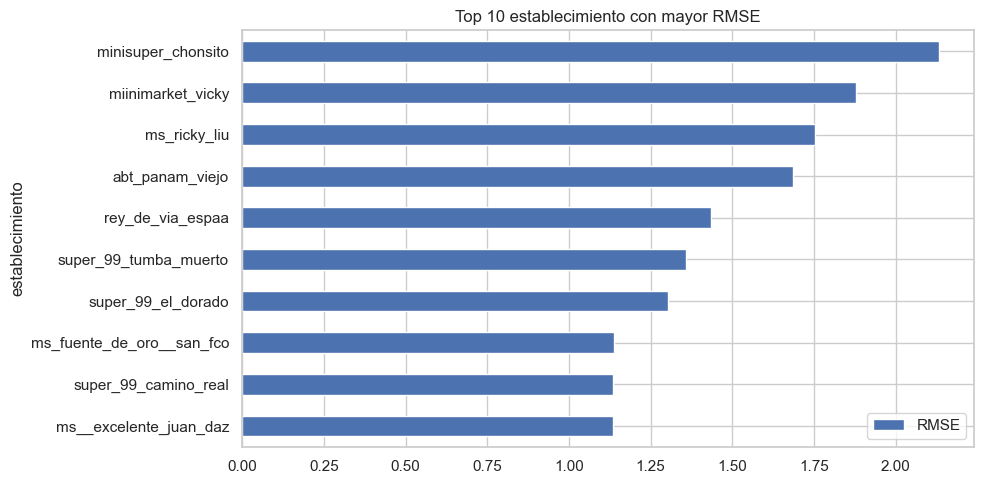

In [12]:
# ============================
# 8) Análisis de error por segmento
# ============================

# Unimos predicciones con metadata
df_test_eval = df.loc[X_test.index].copy()  # Aseguramos que coincidan los índices

df_test_eval["y_real"] = y_test.values
df_test_eval["y_pred"] = y_pred_hgb  # Usamos modelo HGB
df_test_eval["error"] = df_test_eval["y_real"] - df_test_eval["y_pred"]
df_test_eval["abs_error"] = df_test_eval["error"].abs()
df_test_eval["squared_error"] = df_test_eval["error"] ** 2

# Segmentos a evaluar (ajustados a columnas existentes)
segmentos = ["producto", "establecimiento"]

for seg in segmentos:
    print(f"\n📊 Análisis de error por: {seg}")
    seg_stats = df_test_eval.groupby(seg).agg(
        n_obs=("error", "count"),
        RMSE=("squared_error", lambda x: np.sqrt(np.mean(x))),
        MAE=("abs_error", "mean"),
        R2=("y_real", lambda y: r2_score(y, df_test_eval.loc[y.index, "y_pred"])),
        y_real_avg=("y_real", "mean"),
        y_pred_avg=("y_pred", "mean")
    ).sort_values("RMSE", ascending=False)

    # Métrica RMSE normalizada para comparar segmentos con distinto rango
    seg_stats["RMSE_normalized"] = seg_stats["RMSE"] / seg_stats["y_real_avg"]

    print(seg_stats.head(10))  # Top 10 segmentos con más error

    # Guardar resultados
    seg_stats.to_csv(os.path.join(results_dir, f"segment_error_{seg}.csv"))

    # Gráfico opcional
    seg_stats.head(10).plot(kind="barh", y="RMSE", figsize=(10, 5), title=f"Top 10 {seg} con mayor RMSE")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()